In [100]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

### Load previously generated embedding csv files

In [81]:
def process_csv_files(embedding_folder, has_header=True, skip_first_column=False):
    csv_files = glob(embedding_folder + '/*.csv')
    all_embeddings = []

    for csv_file in csv_files:
                                                                    # Read the CSV file
        embeddings_df = pd.read_csv(csv_file, header=0 if has_header else None)
        
        if skip_first_column:                                       # Skip the first column for video csv files
            embeddings_df = embeddings_df.iloc[:, 1:]               # because it contains the name of video frame

    
        embeddings_array = embeddings_df.astype(np.float64).values  # Convert all elements to numpy.float64
                                                                    # Remove rows with NaN values
        embeddings_array = embeddings_array[~np.isnan(embeddings_array).any(axis=1)]
        all_embeddings.append(embeddings_array)                     # Append the NumPy array to the list
        

    # Concatenate all embeddings into a single NumPy array
    embeddings_array = np.concatenate(all_embeddings, axis=0)

    return embeddings_array

text_embedding_folder = 'DATASET-TextEmbedding'
vid_embedding_folder = 'DATASET-VideoEmbeddings'

text_embeddings = process_csv_files(text_embedding_folder, has_header=False)
video_embeddings = process_csv_files(vid_embedding_folder, has_header=True, skip_first_column=True)


In [82]:
print(text_embeddings)
print(video_embeddings)

[[-0.33789062  0.19824219 -0.296875   ... -0.15917969  0.03417969
   0.09179688]
 [-0.28710938  0.29296875 -0.04467773 ... -0.01049805 -0.25976562
   0.11083984]
 [-0.06933594  0.15332031 -0.02490234 ...  0.06054688 -0.19238281
   0.27148438]
 ...
 [-0.01116943  0.06738281  0.13867188 ...  0.18066406 -0.23730469
  -0.17578125]
 [-0.08251953  0.12988281  0.18945312 ...  0.18164062  0.03271484
  -0.09472656]
 [-0.0279541   0.03369141 -0.03027344 ...  0.13574219 -0.0004921
   0.26171875]]
[[0.96737421 0.94864553 0.93027443 ... 0.88816762 1.02650452 0.98235989]
 [0.97024786 0.97135627 0.97625911 ... 0.92484605 1.05267894 0.94103754]
 [0.95929432 0.97145921 0.97567111 ... 0.93477076 1.09334481 0.89381284]
 ...
 [0.87987137 0.9994846  1.00720835 ... 0.91209149 1.10154176 0.98179394]
 [0.86699724 1.04539263 0.90224159 ... 0.91217023 1.14227533 0.93422842]
 [0.8895027  0.96568727 0.93459833 ... 0.89999688 1.05757153 0.93650216]]


In [83]:
# Check data types in the video_embeddings array
print("Data Types in video_embeddings:", set(type(item) for row in video_embeddings for item in row))

Data Types in video_embeddings: {<class 'numpy.float64'>}


### Pre-processing

##### **Note:** 
Even though calling fit_transform separately for text and video embeddings because it could lead to normalization based on different statistics for each set, since the embedding dimensions are not initially equal the image embeddings needs to be processed separately.

In [84]:
# Normalize the text embeddings -----------------------------
scaler_text = StandardScaler()
text_embeddings_normalized = scaler_text.fit_transform(text_embeddings)

# Normalize the video embedding ------------------------------
# video_embeddings.shape is (11000, 512)
# now we will aggregate frame embeddings into video embeddings

# Reshape video embeddings to (num_videos, num_frames_per_video, video_embedding_dim)
num_videos = 50
num_frames_per_video = 220
video_embedding_dim = 512
video_embeddings_reshaped = video_embeddings.reshape(num_videos, num_frames_per_video, video_embedding_dim)
video_embeddings_aggregated = np.mean(video_embeddings_reshaped, axis=1)
scaler_video = StandardScaler()
video_embeddings_normalized = scaler_video.fit_transform(video_embeddings_aggregated)

# Ensure same dimensionality ---------------------------------
# Find the minimum dimensionality among text and video embeddings and trim embeddings to the minimum dimensionality
min_dim = min(text_embeddings_normalized.shape[1], video_embeddings_normalized.shape[1])
text_embeddings_normalized = text_embeddings_normalized[:, :min_dim]
video_embeddings_normalized = video_embeddings_normalized[:, :min_dim]

# Convert normalized NumPy array back to PyTorch tensor
text_embeddings_normalized_tensor = torch.tensor(text_embeddings_normalized, dtype=torch.float32)
print("------------------------------------------------------------------------------")
print("This indicates that there are 50 videos,", len(text_embeddings),"sentences and each frame is\nrepresented by a 512-dimensional embedding" )
print("text_embeddings.shape:             ",text_embeddings.shape)
print("text_embeddings_normalized.shape:  ",text_embeddings_normalized.shape)
print("text_embeddings_normalized_tensor: ",text_embeddings_normalized_tensor.shape)
print("------------------------------------------------------------------------------")

# Convert normalized NumPy array back to PyTorch tensor
video_embeddings_normalized_tensor = torch.tensor(video_embeddings_normalized, dtype=torch.float32)
print("------------------------------------------------------------------------------")
print("This indicates that there are 50 videos, 11000 frames and each frame is\nrepresented by a 512-dimensional embedding" )
print("video_embeddings.shape:             ",video_embeddings.shape)
print("video_embeddings_reshaped.shape:    ",video_embeddings_reshaped.shape)
print("video_embeddings_normalized_tensor: ",video_embeddings_normalized_tensor.shape)
print("------------------------------------------------------------------------------")


------------------------------------------------------------------------------
This indicates that there are 50 videos, 117987 sentences and each frame is
represented by a 512-dimensional embedding
text_embeddings.shape:              (117987, 300)
text_embeddings_normalized.shape:   (117987, 300)
text_embeddings_normalized_tensor:  torch.Size([117987, 300])
------------------------------------------------------------------------------
------------------------------------------------------------------------------
This indicates that there are 50 videos, 11000 frames and each frame is
represented by a 512-dimensional embedding
video_embeddings.shape:              (11000, 512)
video_embeddings_reshaped.shape:     (50, 220, 512)
video_embeddings_normalized_tensor:  torch.Size([50, 300])
------------------------------------------------------------------------------


##### **Check if dimensions of subtitle embeddings match the dimensions of video embeddings**

In [85]:
text_embeddings_normalized_tensor.shape[1] == video_embeddings_normalized_tensor.shape[1] 

True

### Text and Vision Encoder

In [86]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, projection_dim, num_layers=2, dropout_rate=0.1):
        super(ProjectionHead, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, projection_dim))
        for _ in range(num_layers):
            layers.extend([nn.ReLU(), nn.Linear(projection_dim, projection_dim), nn.Dropout(dropout_rate)])
        self.projection = nn.Sequential(*layers)

    def forward(self, x):
        return self.projection(x)

class VisionEncoder(nn.Module):
    def __init__(self, input_channels, projection_dim):
        super(VisionEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_channels, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

class TextEncoder(nn.Module):
    def __init__(self, input_dim, projection_dim):
        super(TextEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

### Create PyTorch Dataset of Text and Video Embeddings

In [88]:
class EmbeddingsDataset(Dataset):
    def __init__(self, video_embeddings, text_embeddings):
        self.video_embeddings = video_embeddings
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.video_embeddings)

    def __getitem__(self, idx):
        video_embedding = self.video_embeddings[idx]
        text_embedding = self.text_embeddings[idx]

        return {'video_embedding': video_embedding, 'text_embedding': text_embedding}


### PyTorch implementation of the dual encoder

In [90]:
class DualEncoder(nn.Module):
    def __init__(self, text_encoder, vision_encoder, temperature=1.0):
        super(DualEncoder, self).__init__()
        self.text_encoder = text_encoder
        self.vision_encoder = vision_encoder
        self.temperature = temperature
        self.loss_criterion = nn.CrossEntropyLoss()

    def forward(self, captions, images):
        # Get the embeddings
        caption_embeddings = self.text_encoder(captions)
        image_embeddings = self.vision_encoder(images)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # Calculate dot-product similarity for captions and images.
        logits = torch.matmul(caption_embeddings, image_embeddings.t()) / self.temperature
        captions_similarity = torch.matmul(caption_embeddings, caption_embeddings.t())
        images_similarity = torch.matmul(image_embeddings, image_embeddings.t())
        # Targets: average of similarities between captions and images.
        targets = torch.nn.functional.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature), dim=1
        )
        # Compute the loss using crossentropy.
        captions_loss = self.loss_criterion(logits, torch.argmax(targets, dim=1))
        images_loss = self.loss_criterion(logits.t(), torch.argmax(targets, dim=0))
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def training_step(self, captions, images):
        # Forward pass
        caption_embeddings, image_embeddings = self(captions, images)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        return loss

    def validation_step(self, captions, images):
        caption_embeddings, image_embeddings = self(captions, images)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        return loss


### Train the model
#### 1. Create Vision and Text Encoders
These encoders are responsible for transforming the input data (video frames and text) into a shared embedding space.
#### 2. Create DataLoader
Prepare data to iterate over batches of paired video and text embeddings. Each batch should contain corresponding video and text embeddings that you want to train on
#### 3. Instantiate Dual Encoder
This model takes the output embeddings from the VisionEncoder and TextEncoder and computes the loss based on the similarity between the embeddings.
#### 4. Training Loop
Iterates through DataLoader batches and train the Dual Encoder. In each iteration, video and text embeddings are passed through the VisionEncoder and TextEncoder, respectively. Then, these embeddings are fed to the Dual Encoder and compute the loss. Finally, backpropagate the gradients and update the model parameters.

#### Simple training and evaluation & Loss over epoch graph

In [97]:
# Instantiate DataLoader to iterate over batches
video_embeddings_normalized_tensor = torch.rand((32, 300))
text_embeddings_normalized_tensor = torch.rand((32, 300))
embeddings_dataset = EmbeddingsDataset(video_embeddings_normalized_tensor, text_embeddings_normalized_tensor)
dataloader = DataLoader(embeddings_dataset, batch_size=32, shuffle=True)

# Instantiate VisionEncoder, TextEncoder
vision_encoder = VisionEncoder(input_channels=300, projection_dim=512)
text_encoder = TextEncoder(input_dim=300, projection_dim=512)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=1.0)

In [98]:
# Training loop
optimizer = torch.optim.Adam(dual_encoder.parameters(), lr=0.001)
num_epochs = 10

# Lists to store training losses
train_losses = []

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in dataloader:
        captions, images = batch['text_embedding'], batch['video_embedding']
        optimizer.zero_grad()
        # Forward pass
        caption_embeddings, image_embeddings = dual_encoder(captions, images)
        # Compute loss and backward pass
        loss = dual_encoder.compute_loss(caption_embeddings, image_embeddings)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    # Calculate and store the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss}")

Epoch [1/10], Loss: 0.8642113208770752
Epoch [2/10], Loss: 0.3001125454902649
Epoch [3/10], Loss: 1.562559723854065
Epoch [4/10], Loss: 1.7220237255096436
Epoch [5/10], Loss: 1.6792937517166138
Epoch [6/10], Loss: 1.6742491722106934
Epoch [7/10], Loss: 1.6865609884262085
Epoch [8/10], Loss: 1.7235586643218994
Epoch [9/10], Loss: 1.6876660585403442
Epoch [10/10], Loss: 1.6301881074905396


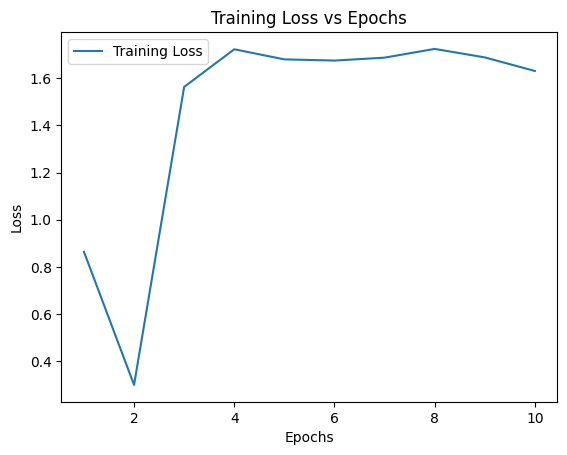

In [101]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

#### Another trial to compare loss over epochs between training and validation set

In [102]:
from torch.utils.data.dataset import random_split

In [103]:
video_embeddings_normalized_tensor = torch.rand((1000, 300))
text_embeddings_normalized_tensor = torch.rand((1000, 300))

# Split the dataset into training and validation sets
total_samples = len(video_embeddings_normalized_tensor)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = random_split(
    EmbeddingsDataset(video_embeddings_normalized_tensor, text_embeddings_normalized_tensor),
    [train_size, val_size]
)

# DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Instantiate VisionEncoder, TextEncoder
vision_encoder = VisionEncoder(input_channels=300, projection_dim=512)
text_encoder = TextEncoder(input_dim=300, projection_dim=512)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=1.0)


In [104]:
# Training loop
optimizer = torch.optim.Adam(dual_encoder.parameters(), lr=0.001)
num_epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []

    # Training
    dual_encoder.train()
    for batch in train_dataloader:
        captions, images = batch['text_embedding'], batch['video_embedding']
        optimizer.zero_grad()
        caption_embeddings, image_embeddings = dual_encoder(captions, images)
        loss = dual_encoder.compute_loss(caption_embeddings, image_embeddings)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    # Validation
    dual_encoder.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            captions, images = batch['text_embedding'], batch['video_embedding']
            caption_embeddings, image_embeddings = dual_encoder(captions, images)
            loss = dual_encoder.compute_loss(caption_embeddings, image_embeddings)
            epoch_val_losses.append(loss.item())

    # Calculate and store the average loss for the epoch
    avg_epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    avg_epoch_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    train_losses.append(avg_epoch_train_loss)
    val_losses.append(avg_epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss}, Val Loss: {avg_epoch_val_loss}")


Epoch [1/10], Train Loss: 3.4648705291748048, Val Loss: 3.1572892665863037
Epoch [2/10], Train Loss: 3.2812914514541625, Val Loss: 3.5083357266017368
Epoch [3/10], Train Loss: 3.324400863647461, Val Loss: 2.6705634083066667
Epoch [4/10], Train Loss: 2.2563497114181517, Val Loss: 2.5431813171931674
Epoch [5/10], Train Loss: 1.9694515371322632, Val Loss: 2.2953215667179654
Epoch [6/10], Train Loss: 2.0031726455688474, Val Loss: 2.2194624628339494
Epoch [7/10], Train Loss: 1.9146224975585937, Val Loss: 1.8846782786505563
Epoch [8/10], Train Loss: 1.6500506567955018, Val Loss: 2.1423008101327077
Epoch [9/10], Train Loss: 1.4537867856025697, Val Loss: 2.274964758328029
Epoch [10/10], Train Loss: 1.4075294345617295, Val Loss: 1.815359047480992


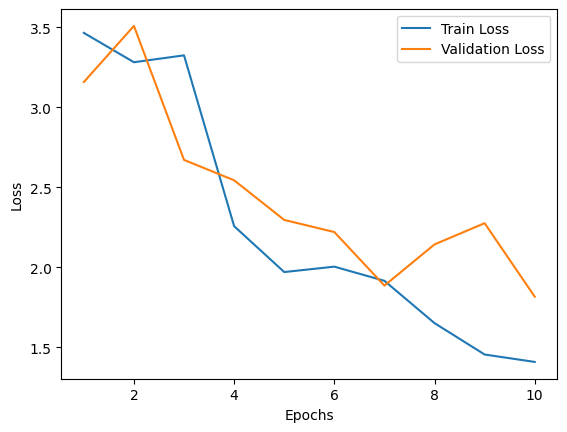

In [105]:
# Plot the loss graph
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()